# Conditional Generative Adversarial Network (cGAN)
Let's code a cDCGAN on MNIST. We will need to condition the training of the GAN over the MNIST labels.

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32 # we use 32 instead of original mnist size (28) for simplicity

# Number of channels in the training images.
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# size of labels
label_dim = 10

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

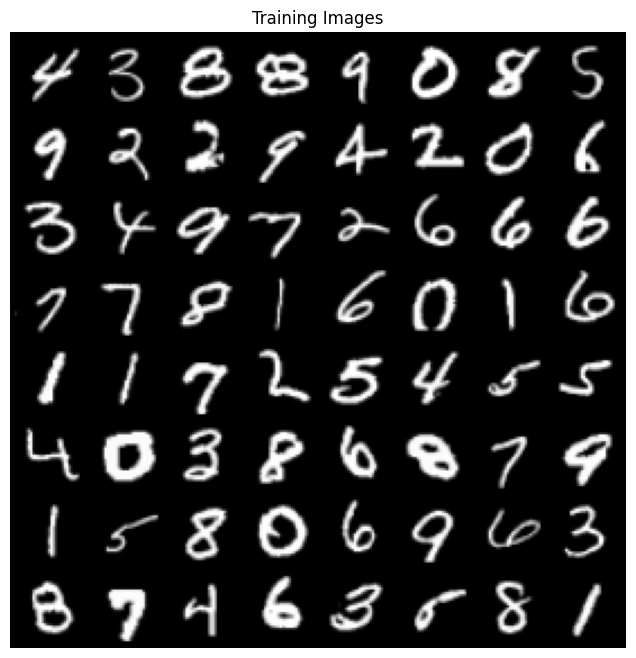

In [3]:
# MNIST dataset
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

mnist_data = dset.MNIST(root='./data',
                         train=True,
                         transform=transform,
                         download=True)

dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weights Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.noise_block = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
         )
        
        self.label_block = nn.Sequential(
            # input are labels, going into a convolution
            nn.ConvTranspose2d(label_dim, ngf * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
         )
        
        self.main = nn.Sequential(
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, noise, labels):
        # first lets pass the noise and the labels...
        # through the corresponding layers
        z_out = self.noise_block(noise)
        l_out = self.label_block(labels)
        # then concatenate them and fed the output to the rest of the generator
        x = torch.cat([z_out, l_out], dim = 1) # concatenation over channels
        return self.main(x)

In [6]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (noise_block): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (label_block): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), paddi

In [7]:
# Batch Normalisation is not used in the critic anymore
# instead we use instance normalization
class Discriminator(nn.Module): # Critic
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.img_block = nn.Sequential(        
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf//2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.label_block = nn.Sequential(        
            # input is (nc) x 32 x 32
            nn.Conv2d(label_dim, ndf//2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )        
        self.main = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)
            # nn.Sigmoid() NO SIGMOID IN WGAN
        )

    def forward(self, img, label):
        # same steps as in generator but with images and labels
        img_out = self.img_block(img)
        lab_out = self.label_block(label)
        x = torch.cat([img_out, lab_out], dim = 1)
        return self.main(x)

In [8]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (img_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (label_block): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [9]:
# Initialize BCELoss function
# criterion = nn.BCELoss() NO NEED FOR BCE LOSS IN WGAN

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(8, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Gradient Penalty
The original WGAN in order to work used weight clipping method to enforce Lipschitz continuity on the critic. 

The interaction between the weight constraint and the loss function makes training of WGAN difficult and leads to exploding or vanishing gradients.

The idea of Gradient Penalty is to enforce a constraint such that the gradients of the critic’s output w.r.t the inputs have unit norm.

Batch Normalization is not used in the critic anymore because batch norm maps a batch of inputs to a batch of outputs. In our case we want to be able to find gradients of each output w.r.t their respective inputs.

(full explanation: https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead)

In [10]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size()).to(device)
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)

In [11]:
# label preprocessing
# for the generator we will use onehot vectors
# for the discriminator we need onehot "images"
onehot = torch.zeros(label_dim, label_dim)

onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(label_dim, 1), 1)
print(onehot)
onehot = onehot.view(label_dim, label_dim, 1, 1)

fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1
print(fill)

print(onehot.size())
print(fill.size())

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
     

In [12]:
# function to generate test sample
def generate_test(fixed_noise, onehot, G):
    G.eval()
    # label 0
    c = (torch.ones(8)*0).type(torch.LongTensor)
    c_onehot = onehot[c].to(device)
    out = G(fixed_noise, c_onehot)
    inference_res = out

    # labels 1-9    
    for l in range(1,label_dim):
        c = (torch.ones(8)*l).type(torch.LongTensor)
        c_onehot = onehot[c].to(device)
        out = G(fixed_noise, c_onehot)
        inference_res = torch.cat([inference_res, out], dim = 0)
    G.train()
    return inference_res

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (imgs, labels) in enumerate(dataloader, 0):
        
        if imgs.size(0) != batch_size:
            continue
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        b_size = imgs.size(0)
        
        # NO NEED FOR LABELS IN WGAN
        # real_label = torch.ones(b_size).to(device)
        # fake_label = torch.zeros(b_size).to(device)
        
        # Format batch
        real_cpu = imgs.to(device)
        c_fill = fill[labels].to(device)
        # Forward pass real batch through D
        output = netD(real_cpu, c_fill).view(-1)
        # Calculate loss on all-real batch
        errD_real = - torch.mean(output)
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        c_onehot = onehot[labels].to(device)
        # Generate fake image batch with G
        fake = netG(noise, c_onehot)
        # Classify all fake batch with D
        c_fill = fill[labels].to(device)
        output = netD(fake.detach(), c_fill).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = torch.mean(output)
        
        # caluculate gradient penalty
        alpha = torch.rand(real_cpu.size(0), 1, 1, 1).to(device) # alpha*x + (1 - alpha)*x_2
        x_hat = (alpha * real_cpu.data + (1 - alpha) * fake.data).requires_grad_(True)
        output = netD(x_hat, c_fill)
        d_loss_gp = gradient_penalty(output, x_hat)
        
        # backpropagate loss
        totalD_loss = errD_real + errD_fake + 10*d_loss_gp
        totalD_loss.backward()
        
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, c_fill).view(-1)
        # Calculate G's loss based on this output
        errG = - torch.mean(output)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generate_test(fixed_noise, onehot, netG).detach().cpu()
            im_grid = vutils.make_grid(fake, padding=2, normalize=True)
            img_list.append(im_grid)
            #vutils.save_image(im_grid, "./res/gan_res/cMNIST_wgan/{}_{}.jpg".format(epoch, iters))

        iters += 1
    #torch.save(netG.state_dict(), "./res/netG_conditional_wgan.pth")

Starting Training Loop...
[0/5][0/469]	Loss_D: -0.6437	Loss_G: 1.3178	D(x): -0.2987	D(G(z)): -0.5264 / -1.3178
[0/5][50/469]	Loss_D: -9.5136	Loss_G: 10.7004	D(x): -0.7131	D(G(z)): -6.7114 / -10.7004
[0/5][100/469]	Loss_D: -7.1777	Loss_G: 13.5544	D(x): -5.3737	D(G(z)): -10.5342 / -13.5544
[0/5][150/469]	Loss_D: -4.1408	Loss_G: 14.2786	D(x): -9.0001	D(G(z)): -12.1863 / -14.2786
[0/5][200/469]	Loss_D: -5.0365	Loss_G: 16.4672	D(x): -10.3388	D(G(z)): -14.0695 / -16.4672
[0/5][250/469]	Loss_D: -3.5595	Loss_G: 14.4735	D(x): -9.8637	D(G(z)): -12.4412 / -14.4735
[0/5][300/469]	Loss_D: -3.8728	Loss_G: 13.8049	D(x): -8.5131	D(G(z)): -11.2308 / -13.8049
[0/5][350/469]	Loss_D: -4.3320	Loss_G: 16.1922	D(x): -11.2112	D(G(z)): -14.2560 / -16.1922
[0/5][400/469]	Loss_D: -4.2583	Loss_G: 15.7948	D(x): -10.9778	D(G(z)): -14.2741 / -15.7948
[0/5][450/469]	Loss_D: -3.9276	Loss_G: 16.4228	D(x): -12.1555	D(G(z)): -14.5104 / -16.4228
[1/5][0/469]	Loss_D: -2.3145	Loss_G: 17.3304	D(x): -14.1463	D(G(z)): -15.7703

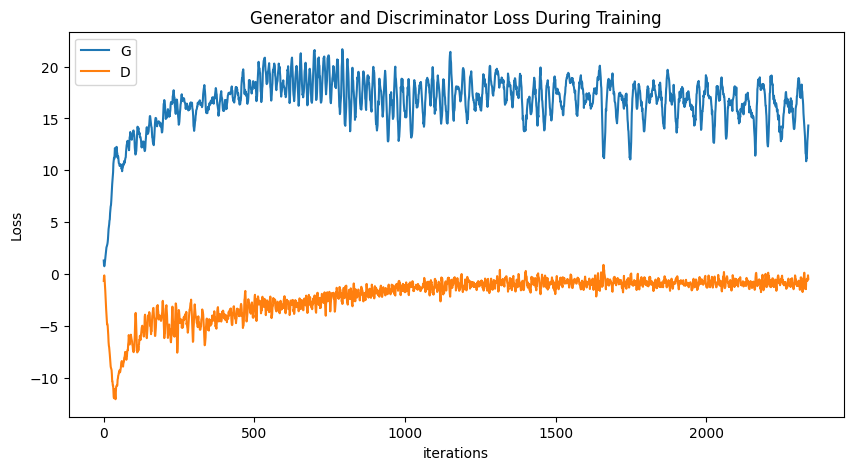

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./res/gan_res/cgan_losses_wgan.png")
plt.show()


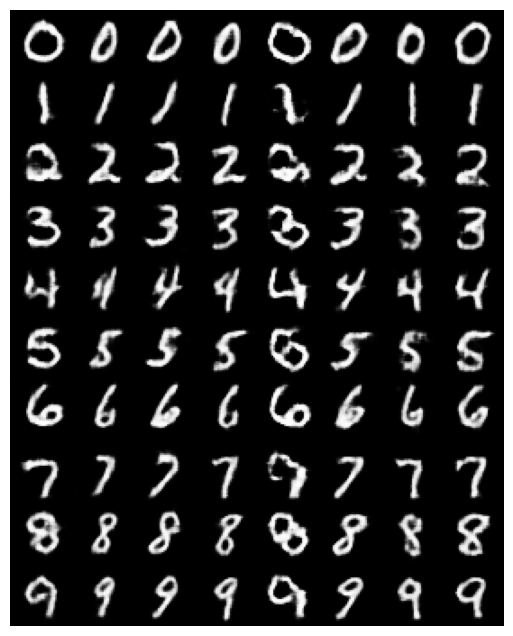

In [15]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())